In [1]:
!pip install ydf koolbox scikit-learn==1.5.2 && pip install --no-deps scikeras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 78.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


# Imports and configs

In [2]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics import root_mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from scikeras.wrappers import KerasRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from ydf import GradientBoostedTreesLearner
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from koolbox import Trainer
import matplotlib.pyplot as plt
import contextlib, io
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import shutil
import optuna
import keras
import json
import glob
import ydf

ydf.verbose(2)
warnings.filterwarnings("ignore")

2025-05-02 14:15:40.250855: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746195340.499265      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746195340.575088      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
class CFG:
    train_path = "/kaggle/input/playground-series-s5e5/train.csv"
    test_path = "/kaggle/input/playground-series-s5e5/test.csv"
    sample_sub_path = "/kaggle/input/playground-series-s5e5/sample_submission.csv"

    metric = root_mean_squared_error
    target = "Calories"
    n_folds = 5
    seed = 42

    cv = KFold(n_splits=n_folds, random_state=seed, shuffle=True)

    run_optuna = True
    n_optuna_trials = 250

# Data loading and preprocessing

In [4]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

train["Sex"] = train["Sex"].map({"male": 0, "female": 1})
test["Sex"] = test["Sex"].map({"male": 0, "female": 1})

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [5]:
mutual_info = mutual_info_regression(X, y, random_state=CFG.seed)

mutual_info = pd.Series(mutual_info)
mutual_info.index = X.columns
mutual_info = pd.DataFrame(mutual_info.sort_values(ascending=False), columns=['Mutual Information'])
mutual_info.style.bar(subset=['Mutual Information'], cmap='RdYlGn')

,Mutual Information
Duration,1.640567
Body_Temp,1.120766
Heart_Rate,0.976966
Age,0.098387
Height,0.056501
Weight,0.055709
Sex,0.017174


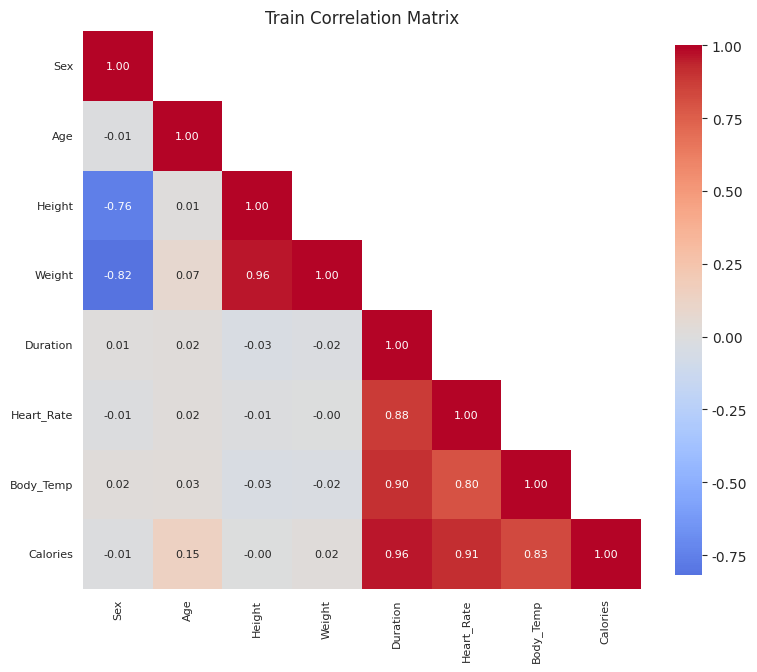

In [6]:
sns.set_style("white")

fig, ax = plt.subplots(figsize=(8, 8))

corr_train = train.corr()
mask_train = np.triu(np.ones_like(corr_train, dtype=bool), k=1)

sns.heatmap(
    data=corr_train,
    annot=True,
    fmt='.2f',
    mask=mask_train,
    square=True,
    cmap='coolwarm',
    cbar_kws={'shrink': .7, 'format': '%.2f'},   
    annot_kws={'size': 8},
    center=0,
    ax=ax
)

ax.set_title('Train Correlation Matrix')
ax.tick_params(axis='both', which='major', labelsize=8)
plt.tight_layout()
plt.show()

# Training base models

In [7]:
histgb_params = {
    "l2_regularization": 10.412017522533768,
    "learning_rate": 0.011702680619474444,
    "max_depth": 59,
    "max_features": 0.30616140080552673,
    "max_iter": 4454,
    "max_leaf_nodes": 385,
    "min_samples_leaf": 50,
    "random_state": 42
}

lgbm_params = {
    "boosting_type": "gbdt",
    "colsample_bytree": 0.8213924491907012,
    "learning_rate": 0.059976685297931195,
    "min_child_samples": 10,
    "min_child_weight": 0.5425237767880097,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 89,
    "random_state": 42,
    "reg_alpha": 2.0325709613371545,
    "reg_lambda": 87.27971117911044,
    "subsample": 0.6452823633939004,
    "verbose": -1
}

lgbm_goss_params = {
    "boosting_type": "goss",
    "colsample_bytree": 0.9068724002629094,
    "learning_rate": 0.06459027654473874,
    "min_child_samples": 39,
    "min_child_weight": 0.5337673729810578,
    "n_estimators": 50000,
    "n_jobs": -1,
    "num_leaves": 13,
    "random_state": 42,
    "reg_alpha": 1.603969498256519,
    "reg_lambda": 10.806488455621444,
    "subsample": 0.5966412222358356,
    "verbose": -1
}

xgb_params = {
    "colsample_bylevel": 0.8606487417581108,
    "colsample_bynode": 0.9410596660335436,
    "colsample_bytree": 0.9407540036296737,
    "early_stopping_rounds": 100,
    "eval_metric": "rmse",
    "gamma": 0.023260595738991977,
    "learning_rate": 0.03669372905801298,
    "max_depth": 11,
    "max_leaves": 51,
    "min_child_weight": 96,
    "n_estimators": 50000,
    "n_jobs": -1,
    "random_state": 42,
    "reg_alpha": 2.953205886504917,
    "reg_lambda": 67.64147033446291,
    "subsample": 0.6973241930754311,
    "verbosity": 0
}

cb_params = {
    "border_count": 88,
    "colsample_bylevel": 0.7903437608890396,
    "depth": 8,
    "eval_metric": "RMSE",
    "iterations": 50000,
    "l2_leaf_reg": 6.065104074215131,
    "learning_rate": 0.030946464122148992,
    "min_child_samples": 138,
    "random_state": 42,
    "random_strength": 0.035251008593976785,
    "verbose": False
}

ydf_params = {
    "num_trees": 800,
    "max_depth": 7
}

In [8]:
scores = {}
oof_preds = {}
test_preds = {}

## HistGradientBoosting

In [9]:
histgb_trainer = Trainer(
    HistGradientBoostingRegressor(**histgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

histgb_trainer.fit(X, y)

scores["HistGB"] = histgb_trainer.fold_scores
oof_preds["HistGB"] = histgb_trainer.oof_preds
test_preds["HistGB"] = histgb_trainer.predict(X_test)

Training HistGradientBoostingRegressor

--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 79.36 s
--- Fold 1 - root_mean_squared_error: 0.0605 - Time: 75.57 s
--- Fold 2 - root_mean_squared_error: 0.0597 - Time: 75.95 s
--- Fold 3 - root_mean_squared_error: 0.0601 - Time: 74.54 s
--- Fold 4 - root_mean_squared_error: 0.0593 - Time: 81.46 s

------ Overall root_mean_squared_error: 0.0599 - Mean root_mean_squared_error: 0.0599 ± 0.0004 - Time: 388.63 s


## LightGBM (gbdt)

In [10]:
lgbm_trainer = Trainer(
    LGBMRegressor(**lgbm_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_trainer.fit(X, y, fit_args=fit_args)

scores["LightGBM (gbdt)"] = lgbm_trainer.fold_scores
oof_preds["LightGBM (gbdt)"] = lgbm_trainer.oof_preds
test_preds["LightGBM (gbdt)"] = lgbm_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0596298	valid_0's l2: 0.00355572
Early stopping, best iteration is:
[1007]	valid_0's rmse: 0.0596274	valid_0's l2: 0.00355543
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 33.27 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0603377	valid_0's l2: 0.00364064
Early stopping, best iteration is:
[1275]	valid_0's rmse: 0.0602791	valid_0's l2: 0.00363357
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 38.42 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0595912	valid_0's l2: 0.00355112
Early stopping, best iteration is:
[1428]	valid_0's rmse: 0.0595689	valid_0's l2: 0.00354846
--- Fold 2 - root_mean_squared_error: 0.0596 - Time: 41.16 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0601792	valid_0's l2: 0.00362153
[2000]	valid_0's rmse: 0.060003

## LightGBM (goss)

In [11]:
lgbm_goss_trainer = Trainer(
    LGBMRegressor(**lgbm_goss_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "eval_metric": "rmse",
    "callbacks": [
        log_evaluation(period=1000), 
        early_stopping(stopping_rounds=100)
    ]
}

lgbm_goss_trainer.fit(X, y, fit_args=fit_args)

scores["LightGBM (goss)"] = lgbm_goss_trainer.fold_scores
oof_preds["LightGBM (goss)"] = lgbm_goss_trainer.oof_preds
test_preds["LightGBM (goss)"] = lgbm_goss_trainer.predict(X_test)

Training LGBMRegressor

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0600119	valid_0's l2: 0.00360142
[2000]	valid_0's rmse: 0.0596893	valid_0's l2: 0.00356281
[3000]	valid_0's rmse: 0.0596226	valid_0's l2: 0.00355485
Early stopping, best iteration is:
[3409]	valid_0's rmse: 0.0596052	valid_0's l2: 0.00355278
--- Fold 0 - root_mean_squared_error: 0.0596 - Time: 99.50 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0607722	valid_0's l2: 0.00369326
[2000]	valid_0's rmse: 0.0603717	valid_0's l2: 0.00364474
[3000]	valid_0's rmse: 0.0602773	valid_0's l2: 0.00363336
Early stopping, best iteration is:
[3393]	valid_0's rmse: 0.0602635	valid_0's l2: 0.00363169
--- Fold 1 - root_mean_squared_error: 0.0603 - Time: 95.90 s

Training until validation scores don't improve for 100 rounds
[1000]	valid_0's rmse: 0.0601257	valid_0's l2: 0.0036151
[2000]	valid_0's rmse: 0.0597138	valid_0's l2: 0.00356574
[3000]	valid_0's 

## XGBoost

In [12]:
xgb_trainer = Trainer(
    XGBRegressor(**xgb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000
}

xgb_trainer.fit(X, y, fit_args=fit_args)

scores["XGBoost"] = xgb_trainer.fold_scores
oof_preds["XGBoost"] = xgb_trainer.oof_preds
test_preds["XGBoost"] = xgb_trainer.predict(X_test)

Training XGBRegressor

[0]	validation_0-rmse:0.92857
[1000]	validation_0-rmse:0.06026
[2000]	validation_0-rmse:0.06020
[3000]	validation_0-rmse:0.06016
[3815]	validation_0-rmse:0.06015
--- Fold 0 - root_mean_squared_error: 0.0601 - Time: 100.52 s

[0]	validation_0-rmse:0.93098
[1000]	validation_0-rmse:0.06155
[2000]	validation_0-rmse:0.06143
[3000]	validation_0-rmse:0.06138
[4000]	validation_0-rmse:0.06134
[5000]	validation_0-rmse:0.06131
[5088]	validation_0-rmse:0.06131
--- Fold 1 - root_mean_squared_error: 0.0613 - Time: 141.31 s

[0]	validation_0-rmse:0.92965
[1000]	validation_0-rmse:0.06074
[2000]	validation_0-rmse:0.06063
[3000]	validation_0-rmse:0.06057
[4000]	validation_0-rmse:0.06053
[4711]	validation_0-rmse:0.06051
--- Fold 2 - root_mean_squared_error: 0.0605 - Time: 126.02 s

[0]	validation_0-rmse:0.92814
[1000]	validation_0-rmse:0.06101
[2000]	validation_0-rmse:0.06097
[2368]	validation_0-rmse:0.06096
--- Fold 3 - root_mean_squared_error: 0.0610 - Time: 66.48 s

[0]	validati

## CatBoost

In [13]:
cb_trainer = Trainer(
    CatBoostRegressor(**cb_params),
    cv=CFG.cv,
    metric=CFG.metric,
    use_early_stopping=True,
    task="regression"
)

fit_args = {
    "verbose": 1000,
    "early_stopping_rounds": 100,
    "use_best_model": True
}

cb_trainer.fit(X, y, fit_args=fit_args)

scores["CatBoost"] = cb_trainer.fold_scores
oof_preds["CatBoost"] = cb_trainer.oof_preds
test_preds["CatBoost"] = cb_trainer.predict(X_test)

Training CatBoostRegressor

0:	learn: 0.9349833	test: 0.9341478	best: 0.9341478 (0)	total: 123ms	remaining: 1h 42m 8s
1000:	learn: 0.0575901	test: 0.0593059	best: 0.0593059 (1000)	total: 54.5s	remaining: 44m 26s
2000:	learn: 0.0565846	test: 0.0591985	best: 0.0591957 (1971)	total: 1m 46s	remaining: 42m 25s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05916685055
bestIteration = 2849

Shrink model to first 2850 iterations.
--- Fold 0 - root_mean_squared_error: 0.0592 - Time: 158.93 s

0:	learn: 0.9343830	test: 0.9365749	best: 0.9365749 (0)	total: 66.3ms	remaining: 55m 13s
1000:	learn: 0.0575543	test: 0.0598443	best: 0.0598443 (1000)	total: 54.7s	remaining: 44m 37s
2000:	learn: 0.0564273	test: 0.0597073	best: 0.0597067 (1997)	total: 1m 48s	remaining: 43m 15s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.05970268328
bestIteration = 2190

Shrink model to first 2191 iterations.
--- Fold 1 - root_mean_squared_error: 0.0597 - Time: 124.78 s

0:	le

## Yggdrasil

In [14]:
def YDFRegressor(learner_class):

    class YDFXRegressor(BaseEstimator, RegressorMixin):

        def __init__(self, params={}):
            self.params = params

        def fit(self, X, y):
            assert isinstance(X, pd.DataFrame)
            assert isinstance(y, pd.Series)
            target = y.name
            params = self.params.copy()
            params['label'] = target
            params['task'] = ydf.Task.REGRESSION
            X = pd.concat([X, y], axis=1)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                self.model = learner_class(**params).train(X)
            return self

        def predict(self, X):
            assert isinstance(X, pd.DataFrame)
            with contextlib.redirect_stderr(io.StringIO()), contextlib.redirect_stdout(io.StringIO()):
                return self.model.predict(X)

    return YDFXRegressor

In [15]:
ydf_trainer = Trainer(
    YDFRegressor(GradientBoostedTreesLearner)(ydf_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ydf_trainer.fit(X, y)

scores["Yggdrasil"] = ydf_trainer.fold_scores
oof_preds["Yggdrasil"] = ydf_trainer.oof_preds
test_preds["Yggdrasil"] = ydf_trainer.predict(X_test)

Training YDFXRegressor

--- Fold 0 - root_mean_squared_error: 0.0605 - Time: 146.86 s
--- Fold 1 - root_mean_squared_error: 0.0606 - Time: 173.55 s
--- Fold 2 - root_mean_squared_error: 0.0602 - Time: 121.77 s
--- Fold 3 - root_mean_squared_error: 0.0612 - Time: 126.72 s
--- Fold 4 - root_mean_squared_error: 0.0602 - Time: 117.13 s

------ Overall root_mean_squared_error: 0.0606 - Mean root_mean_squared_error: 0.0606 ± 0.0004 - Time: 688.02 s


## Neural networks

In [16]:
train = pd.read_csv(CFG.train_path, index_col="id")
test = pd.read_csv(CFG.test_path, index_col="id")

X = train.drop(CFG.target, axis=1)
y = np.log1p(train[CFG.target])
X_test = test

In [17]:
pipeline = make_pipeline(
    ColumnTransformer(
        [
            ('one-hot-encode', OneHotEncoder(drop='first', sparse_output=False, dtype=np.float32, handle_unknown='ignore'), ['Sex']),
            
        ],
        remainder=StandardScaler()
    )
).set_output(transform='pandas')

X = pipeline.fit_transform(X, y)
X_test = pipeline.transform(X_test)

In [18]:
def get_model(meta):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(meta["X_shape_"][1:]))
    model.add(keras.layers.Dense(256, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(128, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(64, kernel_initializer='lecun_normal', activation='selu'))
    model.add(keras.layers.Dense(1))
    return model

In [19]:
nn_model = KerasRegressor(
    get_model,
    loss="mean_squared_error",
    random_state=CFG.seed,
    metrics=[keras.metrics.RootMeanSquaredError(name='rmse')],
    optimizer=keras.optimizers.AdamW(learning_rate=0.001),
    validation_batch_size=65536,
    validation_split=0.1,
    batch_size=1024,
    epochs=100, 
    verbose=0,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_rmse', patience=7, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='val_rmse', patience=3, factor=0.3)
    ]
)

2025-05-02 15:11:24.376117: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [20]:
nn_trainer = Trainer(
    nn_model,
    cv=CFG.cv,
    metric=root_mean_squared_error,
    task="regression"
)

nn_trainer.fit(X, y)

scores["KerasANN"] = nn_trainer.fold_scores
oof_preds["KerasANN"] = nn_trainer.oof_preds
test_preds["KerasANN"] = nn_trainer.predict(X_test)

Training KerasRegressor



2025-05-02 15:11:24.879478: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:11:31.119826: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 0 - root_mean_squared_error: 0.0605 - Time: 267.68 s


2025-05-02 15:16:00.115641: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:20:30.623804: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 1 - root_mean_squared_error: 0.0614 - Time: 278.77 s


2025-05-02 15:20:37.954256: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:24:14.697914: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 2 - root_mean_squared_error: 0.0615 - Time: 223.67 s


2025-05-02 15:24:21.881219: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:27:29.952460: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 3 - root_mean_squared_error: 0.0616 - Time: 194.85 s


2025-05-02 15:27:37.210058: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_15}}
2025-05-02 15:32:01.249944: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

--- Fold 4 - root_mean_squared_error: 0.0612 - Time: 270.91 s

------ Overall root_mean_squared_error: 0.0612 - Mean root_mean_squared_error: 0.0612 ± 0.0004 - Time: 1238.02 s


2025-05-02 15:32:07.288087: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_14}}


# Ensembling with Ridge

In [21]:
def plot_weights(weights, title):
    sorted_indices = np.argsort(weights[0])[::-1]
    sorted_coeffs = np.array(weights[0])[sorted_indices]
    sorted_model_names = np.array(list(oof_preds.keys()))[sorted_indices]

    plt.figure(figsize=(10, weights.shape[1] * 0.5))
    ax = sns.barplot(x=sorted_coeffs, y=sorted_model_names, palette="RdYlGn_r")

    for i, (value, name) in enumerate(zip(sorted_coeffs, sorted_model_names)):
        if value >= 0:
            ax.text(value, i, f"{value:.3f}", va="center", ha="left", color="black")
        else:
            ax.text(value, i, f"{value:.3f}", va="center", ha="right", color="black")

    xlim = ax.get_xlim()
    ax.set_xlim(xlim[0] - 0.1 * abs(xlim[0]), xlim[1] + 0.1 * abs(xlim[1]))

    plt.title(title)
    plt.xlabel("")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

In [22]:
X = pd.DataFrame(oof_preds)
X_test = pd.DataFrame(test_preds)

In [23]:
def objective(trial):    
    params = {
        "random_state": CFG.seed,
        "alpha": trial.suggest_float("alpha", 0, 10),
        "tol": trial.suggest_float("tol", 1e-6, 1e-2)
    }
    
    trainer = Trainer(
        Ridge(**params),
        cv=CFG.cv,
        metric=CFG.metric,
        task="regression",
        verbose=False
    )
    trainer.fit(X, y)
    
    return trainer.overall_score

if CFG.run_optuna:
    sampler = optuna.samplers.TPESampler(seed=CFG.seed, multivariate=True)
    study = optuna.create_study(direction="minimize", sampler=sampler)
    study.optimize(objective, n_trials=CFG.n_optuna_trials, n_jobs=-1, catch=(ValueError,))
    best_params = study.best_params

    ridge_params = {
        "random_state": CFG.seed,
        "alpha": best_params["alpha"],
        "tol": best_params["tol"]
    }
else:
    ridge_params = {
        "random_state": CFG.seed
    }

[I 2025-05-02 15:32:08,483] A new study created in memory with name: no-name-a8c6eb5b-7d27-4040-9477-b961568d6701
[I 2025-05-02 15:32:16,553] Trial 3 finished with value: 0.059097651656365664 and parameters: {'alpha': 4.281819638342029, 'tol': 0.0029930183325992104}. Best is trial 3 with value: 0.059097651656365664.
[I 2025-05-02 15:32:16,558] Trial 1 finished with value: 0.05909667650472934 and parameters: {'alpha': 1.2277899755412913, 'tol': 0.009593272834491118}. Best is trial 1 with value: 0.05909667650472934.
[I 2025-05-02 15:32:16,559] Trial 2 finished with value: 0.059096677978039296 and parameters: {'alpha': 0.6282076381768031, 'tol': 0.008159840992483049}. Best is trial 1 with value: 0.05909667650472934.
[I 2025-05-02 15:32:16,568] Trial 0 finished with value: 0.05909920411302173 and parameters: {'alpha': 6.612493875334779, 'tol': 0.009462643296391949}. Best is trial 1 with value: 0.05909667650472934.
[I 2025-05-02 15:32:25,350] Trial 4 finished with value: 0.05910147945366853

In [24]:
print(json.dumps(ridge_params, indent=2))

{
  "random_state": 42,
  "alpha": 0.9335439747856088,
  "tol": 0.009981873786346858
}


In [25]:
ridge_trainer = Trainer(
    Ridge(**ridge_params),
    cv=CFG.cv,
    metric=CFG.metric,
    task="regression"
)

ridge_trainer.fit(X, y)

scores["Ridge (ensemble)"] = ridge_trainer.fold_scores
ridge_test_preds = np.expm1(ridge_trainer.predict(X_test))

Training Ridge

--- Fold 0 - root_mean_squared_error: 0.0590 - Time: 0.12 s
--- Fold 1 - root_mean_squared_error: 0.0596 - Time: 0.12 s
--- Fold 2 - root_mean_squared_error: 0.0589 - Time: 0.11 s
--- Fold 3 - root_mean_squared_error: 0.0593 - Time: 0.11 s
--- Fold 4 - root_mean_squared_error: 0.0586 - Time: 0.11 s

------ Overall root_mean_squared_error: 0.0591 - Mean root_mean_squared_error: 0.0591 ± 0.0003 - Time: 2.72 s


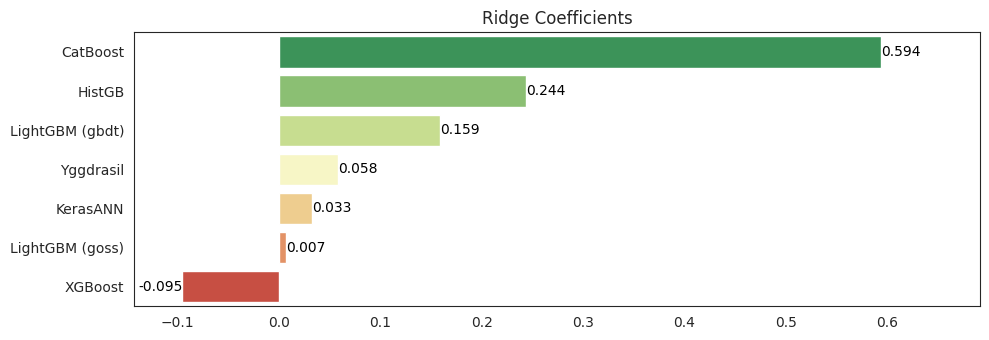

In [26]:
ridge_coeffs = np.zeros((1, X.shape[1]))
for m in ridge_trainer.estimators:
    ridge_coeffs += m.coef_
ridge_coeffs = ridge_coeffs / len(ridge_trainer.estimators)

plot_weights(ridge_coeffs, "Ridge Coefficients")

# Submission

In [27]:
sub = pd.read_csv(CFG.sample_sub_path)
sub[CFG.target] = ridge_test_preds
sub.to_csv(f"sub_ridge_{np.mean(scores['Ridge (ensemble)']):.6f}.csv", index=False)
sub.head()

,id,Calories
0,750000,27.213713
1,750001,107.654525
2,750002,87.023313
3,750003,125.552176
4,750004,76.040043


# Results

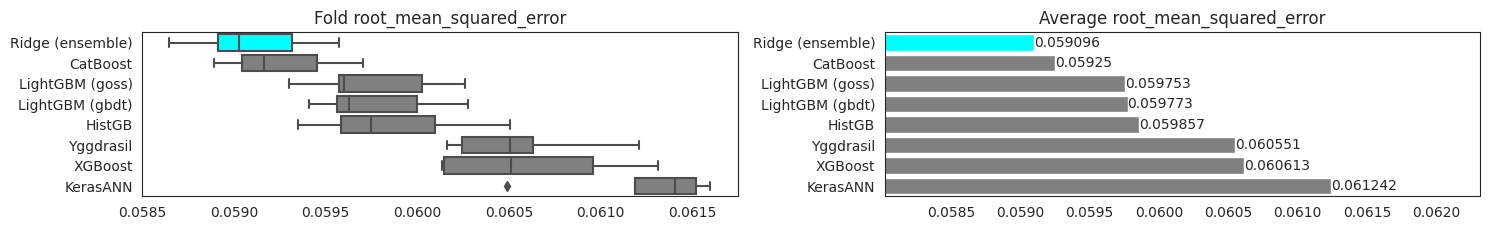

In [28]:
scores = pd.DataFrame(scores)
mean_scores = scores.mean().sort_values(ascending=True)
order = scores.mean().sort_values(ascending=True).index.tolist()

min_score = mean_scores.min()
max_score = mean_scores.max()
padding = (max_score - min_score) * 0.5
lower_limit = min_score - padding
upper_limit = max_score + padding

fig, axs = plt.subplots(1, 2, figsize=(15, scores.shape[1] * 0.3))

boxplot = sns.boxplot(data=scores, order=order, ax=axs[0], orient="h", color="grey")
axs[0].set_title(f"Fold {CFG.metric.__name__}")
axs[0].set_xlabel("")
axs[0].set_ylabel("")

barplot = sns.barplot(x=mean_scores.values, y=mean_scores.index, ax=axs[1], color="grey")
axs[1].set_title(f"Average {CFG.metric.__name__}")
axs[1].set_xlabel("")
axs[1].set_xlim(left=lower_limit, right=upper_limit)
axs[1].set_ylabel("")

for i, (score, model) in enumerate(zip(mean_scores.values, mean_scores.index)):
    color = "cyan" if "ensemble" in model.lower() else "grey"
    barplot.patches[i].set_facecolor(color)
    boxplot.patches[i].set_facecolor(color)
    barplot.text(score, i, round(score, 6), va="center")

plt.tight_layout()
plt.show()

In [29]:
shutil.rmtree("catboost_info", ignore_errors=True)